# Continue Training More Epochs from last one saved
Notebook is setup specifically for MAnet  to continue training from a checkpoint.

It also continues updating the same log

In [1]:
from datetime import datetime
import os
from pathlib import Path
import numpy as np
import copy
import cv2
from tqdm import tqdm
import gc
from torch import cuda
import pandas as pd

import torch
import torchvision.transforms as tf
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics.functional import accuracy as acc  


### Get data sources

TrainFolder should be the folder where the images and labels subfolder are stored
if a label is absent for a tile, an empty one is used as default.

In [2]:
TrainFolder="./Data/trainData/A1234/"
ListImages=os.listdir(os.path.join(TrainFolder, "images")) # Create list of images

ValidFolder="./Data/trainData/Arundo4/"  #Used for validation and evaluation after training
vListImages=os.listdir(os.path.join(ValidFolder, "images")) # Create list of validation images

### necessary parameters

In [3]:
width=height=256 # image width and height  ( USED to generate a default empty label)
batch_size=24 #acceptable sizes on a 24GB GPU:  48 for 256x256 tiles and 16 for 512x512 tiles
epochs=200  #looping

## declaration of necessary functions

In [4]:
# Data Transformation

tensorise=tf.ToTensor()

def AdaptMask(Lbl):   #function to adapt mask to Tensor
    Lbl=Lbl.astype(np.float32)
    Lbl=Lbl/10
    Lbl=Lbl.astype(int)
    Lbl=tensorise(Lbl)
    return Lbl
    

transformImg= tf.Compose([tf.ToPILImage(),tf.ToTensor(),tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]) #function to adapt image
# Normalize parameters are suggested by PyTorch documentation

In [5]:
#_____These are required if training on batches of Random images instead of all the trainset equally______


def ReadRandomImage(): # Used if training on randomly selected images
    idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, "images", ListImages[idx]), cv2.IMREAD_COLOR)[:,:,0:3]
    Img=transformImg(Img)
    
    if Path(os.path.join(TrainFolder, "labels", ListImages[idx])).is_file():
            Lbl=cv2.imread(os.path.join(TrainFolder, "labels", ListImages[idx]), cv2.COLOR_GRAY2BGR ) 
            Lbl=AdaptMask(Lbl)
    else: 
            Lbl=torch.zeros(width, height,dtype=torch.int32)
   
    return Img,Lbl



def LoadBatch(): # Load batch of Random images
    images = torch.zeros([batch_size,3,height,width])
    labels = torch.zeros([batch_size, height, width])
    for i in range(batch_size):
        images[i],labels[i]=ReadRandomImage()

    return images, labels


In [6]:

#  This used to load the batches of size BatchSize from the selected folder

def LoadNext(batchNum,batchSize,folder):
    ListOfImages=os.listdir(os.path.join(folder, "images"))
    images = torch.zeros([batchSize,3,height,width])
    labels = torch.zeros([batchSize, height, width])
    for item in range(batchSize):
        idx=(batchNum*batchSize)+item 
        #print ("idx:",idx, "  path:", os.path.join(folder, "labels", ListOfImages[idx]) )
        Img=cv2.imread(os.path.join(folder, "images", ListOfImages[idx]), cv2.IMREAD_COLOR)[:,:,0:3]
        Img=transformImg(Img)
        
        # now we check if the label exists.  We read it ELSE generate blank tensor
        if Path(os.path.join(folder, "labels", ListImages[idx])).is_file():
            Lbl=cv2.imread(os.path.join(folder, "labels", ListOfImages[idx]), cv2.COLOR_GRAY2BGR )#[:,:,0:3]
            Lbl=AdaptMask(Lbl)
        else: 
            Lbl=torch.zeros(width, height,dtype=torch.int32)
        
        
        images[item]=Img
        labels[item]=Lbl
            
    return images,labels

In [7]:
def learn(imgs,lbls):
    
    images=torch.autograd.Variable(imgs,requires_grad=False).to(device) # Load image
    labels = torch.autograd.Variable(lbls, requires_grad=False).to(device) # Load labels
    Pred=Net(images)#['out'] # make prediction
    Net.zero_grad()
    criterion = torch.nn.CrossEntropyLoss() # Set loss function
    Loss=criterion(Pred,labels.long()) # Calculate cross entropy loss
    Loss.backward() # Backpropogate loss
    this_loss=Loss.data.cpu().numpy()
    optimizer.step() #not used see if necessary
    return this_loss


def validate(imgs,lbls):
    
    images=torch.autograd.Variable(imgs,requires_grad=False).to(device) # Load image
    labels = torch.autograd.Variable(lbls, requires_grad=False).to(device) # Load labels
    Pred=Net(images)#['out'] # make prediction
    Net.zero_grad()
    criterion = torch.nn.CrossEntropyLoss() # Set loss function
    Loss=criterion(Pred,labels.long()) # Calculate cross entropy loss
    this_loss=Loss.data.cpu().numpy()
    
    tp, fp, fn, tn = smp.metrics.get_stats(Pred[0:batch_size,1], lbls.long().to(device), mode='binary', threshold=0.5)
    accuracy = acc(tp, fp, fn, tn, reduction="micro")
    
    return this_loss , float(accuracy)

## Setup the model and prepare for training

classsegmentation_models_pytorch.MAnet(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_pab_channels=64, in_channels=3, classes=1, activation=None, aux_params=None)

More Models: https://smp.readthedocs.io/en/stable/models.html 
Backbones to choose from:  https://smp.readthedocs.io/en/stable/encoders.html 

In [8]:
model = smp.MAnet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use None or `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset, add +1 for background)
    # activation='softmax',  #deprecated for some models.  Last activation is self(x)
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device: ", device)

Net = model # Load net
Net=Net.to(device)

#model_naming_title="MaNet-ENb7"


device:  cuda


# Continue training a model  FROM CHECKPOINT
This includes:
>using a log to keep track of training progress

>continue training from the last checkpoint (number & learning rate detected from log)

> Saving the last Epoch in the loop regardless of result (in case you want to continue training from it later)

In [9]:
model_naming_title="MaNet-ENb7"  #MaNet with backbone EfficientNet-b7

log_path='LOG for '+model_naming_title+'.csv'
log_titles=['Epoch','Train-Loss','Val-Loss', 'Acc', 'Learn-Rate','Session','CheckPoint']
log_DB=pd.DataFrame( columns=log_titles)

if os.path.exists(log_path):
    print("A log file for ",model_naming_title," was found as: ",log_path)
    log_DB=pd.read_csv(log_path, sep=",", index_col=0)
    path=log_DB.tail(1)['Session']
    path=str(path[0])
    best_loss=log_DB['Train-Loss'].min() #smallest loss value
    LastEpoch=int(log_DB.tail(1)['Epoch'])
    LastCheckpoint=log_DB.tail(1)['CheckPoint']
    Learning_Rate=float(log_DB.tail(1)['Learn-Rate'])  #the last learning rate logged
    EpochsStartFrom=LastEpoch+1
    
    
    if os.path.exists(path):
        print("Folder for checkpoints: ",path, " was found")
        checkpoint ="./"+LastCheckpoint[0] # Path to trained model
        
        if os.path.exists(checkpoint):
            print("Training to continue from checkpoint:", checkpoint)
            
        else: 
            print("Last Checkpoint: ",checkpoint, " was not found.  Training cannot continue")
            #del epochs
            del checkpoint
            print(" Please specify a path to a saved checkpoint manually in the next cell")
    else:
        print("Folder for checkpoints: ",path, " was not found.  Training cannot continue")
        del epochs
        print(" Please restore the folder and restart this notebook, or start training from scratch in appropriate notebook")

else:
    print(" Training Log File:  '",log_path,"'  was not found...  ")
    
    print(" Please restore the log file and restart this notebook, or start training from scratch in appropriate notebook")


#_________________________PREPERATION DONE_________________#

A log file for  MaNet-ENb7  was found as:  LOG for MaNet-ENb7.csv
Folder for checkpoints:  MaNet-ENb7-1641-15-11-2022  was found
Training to continue from checkpoint: ./MaNet-ENb7-1641-15-11-2022/4-1642-MaNet-ENb7.torch


### Load Checkpoint manually (if instructed by previous cell)
You shouldn't need to do this if all works well.  This is provided only as a contingency in case of power cuts or other interruptions to the training.

If no checkpoint has been detected by the previous cell, training won't take place unless you specify a checkpoint.

Uncomment the next cell to specify a checkpoint manually.  Otherwise ignore.

In [ ]:
# checkpoint="./"+path+"/"+"COPY CHECKPOINT NAME HERE"+".torch"

# Main Training Loop

In [ ]:
Net.load_state_dict(torch.load(checkpoint))  #if this gives an error check the training setup in previous 2 cells
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
            
model_naming_title="-"+model_naming_title+".torch"
log_path2="./"+path+'/LOG for '+path+'.csv'
log_DB2=pd.read_csv(log_path2, sep=",", index_col=0)
            
unbatched=len(ListImages)%batch_size
batch_counts=round((len(ListImages)-unbatched)/batch_size)
vunbatched=len(vListImages)%batch_size
vbatch_counts=round((len(vListImages)-vunbatched)/batch_size)

valid_loss=0
ValACC=0


#_________________________TRAINING STARTS FROM HERE_________________#
for itr in range(epochs): # Training loop
    start_time= datetime.now()
    train_loss=0
    runs=batch_counts
    vruns=vbatch_counts
    

    for batchNum in tqdm(range(batch_counts)):
        images,labels=LoadNext(batchNum,batch_size,TrainFolder)
        train_loss=train_loss+learn(images, labels)
        del images
        del labels
        gc.collect()
        cuda.empty_cache()
       
    if unbatched>0:
        images,labels=LoadNext(batch_counts+1,unbatched,TrainFolder)
        train_loss=train_loss+learn(images, labels)
        runs=batch_counts+1
        del images
        del labels
        gc.collect()
        cuda.empty_cache()
    
    #uncomment if you want to train on a random batch too
    """
    images,labels=LoadBatch() 
    train_loss+=learn(images, labels)
    runs=batch_counts+1
    """

    train_loss=train_loss/(runs) # +1) #averages the loss on all batches
    scheduler.step(train_loss)
    
    #BEGIN Validation 
    
    with torch.no_grad():
        valid_loss=0
        ValACC=0
        
        for vbatchNum in tqdm(range(vbatch_counts)):
            images,labels=LoadNext(vbatchNum,batch_size,ValidFolder)
            newVloss,batch_accuracy=validate(images, labels)
            del images
            del labels
            gc.collect()
            cuda.empty_cache()
            valid_loss=valid_loss+newVloss
            ValACC=ValACC+batch_accuracy
       
        if vunbatched>0:
            images,labels=LoadNext(vbatch_counts+1,vunbatched,ValidFolder)
            newVloss,batch_accuracy=validate(images, labels)
            del images
            del labels
            gc.collect()
            cuda.empty_cache()
            valid_loss=valid_loss+newVloss
            ValACC=ValACC+batch_accuracy
            vruns=vbatch_counts+1
        
        valid_loss=valid_loss/(vruns) #averages the loss on all batches
        ValACC=ValACC/(vruns)
            
    #END   Validation 
     
    duration=datetime.now()-start_time
        
    if train_loss<=best_loss:
        best_loss=copy.deepcopy(train_loss)
        t=datetime.now()
        checkpoint=path+"/"+str(itr+EpochsStartFrom)+"-"+str(t.hour)+str(t.minute)+model_naming_title
        print("Saving Model: ", "./"+checkpoint)
        torch.save(Net.state_dict(),"./"+checkpoint)
    else:
        if itr!=epochs-1:  checkpoint="not saved"
        else:
            checkpoint=path+"/"+str(itr+EpochsStartFrom)+"-LAST EPOCH-"+model_naming_title
            torch.save(Net.state_dict(),"./"+checkpoint)
            print(" Saving LAST EPOCH: ./",checkpoint)
        
    print(itr+EpochsStartFrom,"=> TrainLoss=",train_loss,"  ValLoss=", valid_loss,  "ACC=",ValACC, "lr:", scheduler.state_dict()["_last_lr"][0], " Time:", duration.seconds)
    new_log_entry=pd.DataFrame([[itr+EpochsStartFrom, train_loss, valid_loss,ValACC, float(scheduler.state_dict()["_last_lr"][0]),path,checkpoint]], columns=log_titles)
    log_DB=pd.concat([log_DB, new_log_entry])
    log_DB.to_csv(log_path, sep=",")
    log_DB2=pd.concat([log_DB2, new_log_entry])
    log_DB2.to_csv(log_path2, sep=",")

#_________________________TRAINING LOOP ENDS HERE_________________#
        
print("____FINISHED Training______")



### Plot training and validation loss graph

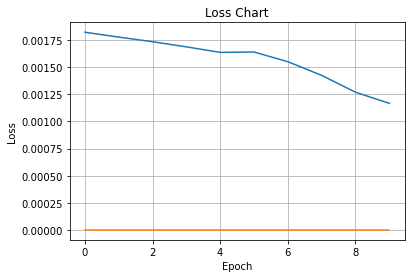

In [12]:
import matplotlib.pyplot as plt

log_DB=pd.read_csv(log_path, sep=",")

xAxis=log_DB['Epoch']
yAxis=log_DB['Train-Loss']
yAxis2=log_DB['Val-Loss']

plt.plot(xAxis,yAxis,xAxis,yAxis2)

plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Evaluate accuracy over all of the training data (tiles)
Uses Confusion Matrix function on each tile/label combo 

### Confusion Matrix function for pixel segmentation (for one class)

segmentation_models_pytorch.metrics.functional.accuracy(tp, fp, fn, tn, reduction=None, class_weights=None, zero_division=1.0)
https://smp.readthedocs.io/en/stable/metrics.html#segmentation_models_pytorch.metrics.functional.accuracy 

In [ ]:
def bitmapConfMatrix(Output, Target):
    tp, fp, fn, tn = smp.metrics.get_stats(Output, Target, mode='multilabel', threshold=0.5)
    
 
    TruePs=int(torch.count_nonzero(tp).cpu().detach().numpy())
    FalsePs=int(torch.count_nonzero(fp).cpu().detach().numpy())
    TrueNs=int(torch.count_nonzero(tn).cpu().detach().numpy())
    FalseNs=int(torch.count_nonzero(fn).cpu().detach().numpy())
    acc=float(smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro"))

    return TruePs,FalsePs,FalseNs,TrueNs, acc
    

### Load Data and Model (if needed, uncomment the following cell & set the modelPath)

In [ ]:
"""
ValidFolder="./Data/trainData/Arundo4/"
vListImages=os.listdir(os.path.join(ValidFolder, "images")) # Create list of validation images

modelPath = "PathToMyBestTrainedModel.torch"  # Path to trained model

Net.load_state_dict(torch.load(modelPath))

"""

### Evaluation Loop

In [ ]:
ValACC=0
tp=0
fp=0
fn=0
tn=0

Net.eval()  #  sets network to evaluation model
with torch.no_grad():  # tells the Net not to perform gradient descent (since we are only evaluating)
    for i in range(len(vListImages)):

        idx=i

        Img=cv2.imread(os.path.join(ValidFolder, "images", vListImages[idx]), cv2.IMREAD_COLOR)#[:,:,0:3]
        Img=transformImg(Img)
        image=torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0) # Load image
        
        Lbl=cv2.imread(os.path.join(ValidFolder, "labels", vListImages[idx]), cv2.COLOR_GRAY2BGR )#[:,:,0:3]
        if type(Lbl)==type(None): Lbl=np.zeros((width, height), dtype=np.int8)
        Lbl=Lbl/10
        Lbl=Lbl.astype(np.int8)
        Target= torch.from_numpy(Lbl).to(device)
        
        Pred=Net(image)
        Output=Pred[0][1]
       
        a,b,c,d,e=bitmapConfMatrix(Output, Target)
        tp=tp+a
        fp=fp+b
        fn=fn+c
        tn=tn+d
        ValACC=ValACC+e
        print("TP:",a ," FP:",b," FN:",c," TN:",d," Acc:", e)
        

ValACC=ValACC/len(vListImages)
print("FINISHED")


In [ ]:
#Generate Result

print("TP:",tp,"  FP:",fp)
print("FN:",fn,"  TN:",tn)
print("\nTP% :",tp/(tp+fp)  )
print("TN% :",tn/(fn+tn))


print("\nAccuracy:", ValACC*100)
